# init

In [5]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS
from rasterio.plot import show
#from shapely.geometry import mapping
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [6]:
def getFeatures(gdf):
    #Function to parse features from GeoDataFrame in such a manner that rasterio wants them
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# input

In [7]:
#input a vector and a raster file
AOI_path = Path('../data/processed/')
#AOI_file = 'MAN_LIM_BoundingBox_AOI_A.shp'
#AOI_file = 'MUM_LIM_BoundingBox_AOI_A.shp'
AOI_file = 'JAK_LIM_BoundingBox_AOI_A.shp'

AOI_gdf = gpd.read_file(AOI_path/AOI_file)
AOI_gdf.to_crs(epsg=4326, inplace=True)

raster_file = Path('../data/processed/raster.tif')
in_raster = rasterio.open(raster_file, 'r+') #note that the raster and AOI must be in the same CRS
print('AOI:', AOI_gdf.crs.to_epsg(),'Raster:', in_raster.crs)

AOI: 4326 Raster: EPSG:4326


In [8]:
#get the coordinates of the AOI
AOI_geom = AOI_gdf.geometry
coords = getFeatures(AOI_gdf)
clipped_array, clipped_transform = mask(dataset=in_raster, shapes=AOI_geom, crop=True)

In [20]:
#setting up the output file
out_path = Path('../data/processed/')
out_file = 'out_raster.tif'
out_url = out_path/out_file

AOI_gdf = AOI_gdf.to_crs(in_raster.crs)
out_meta = in_raster.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": clipped_array.shape[1],
                 "width": clipped_array.shape[2],
                 "transform": clipped_transform})

with rasterio.open(out_url, "w", **out_meta) as dest:
    dest.write(clipped_array)

(106.25443659232573, 107.24453458468031, -6.790987887296184, -5.9243366531867)

c:\Users\ra42zek\AppData\Local\anaconda3\envs\x\Lib\site-packages\matplotlib\colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


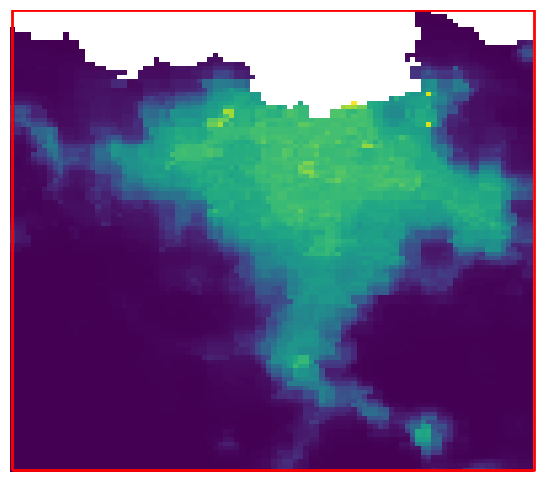

In [21]:
#plotting to be sure it worked
clipped = rasterio.open(out_url)
fig, ax = plt.subplots(figsize=(8, 6))
p1 = AOI_gdf.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(clipped, ax=ax)
ax.axis('off')